In [2]:
#path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

path = r'X:\Processed_data'

In [13]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch.nn as nn

window_size = 30

# Define the number of features (i.e., columns in your dataset)
num_features = 11*window_size

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units1, hidden_units2, latent_features=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=latent_features)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        z = self.encoder(x)
        x_hat = torch.sigmoid(self.decoder(z))
        return {'z': z, 'x_hat': x_hat}

# Initialize the autoencoder model
hidden_units1 = 32*window_size
hidden_units2 = 16*window_size
latent_features = 2*window_size
net = AutoEncoder(hidden_units1, hidden_units2, latent_features)
cuda = torch.cuda.is_available()

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=330, out_features=960, bias=True)
    (1): ReLU()
    (2): Linear(in_features=960, out_features=480, bias=True)
    (3): ReLU()
    (4): Linear(in_features=480, out_features=60, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=480, bias=True)
    (1): ReLU()
    (2): Linear(in_features=480, out_features=960, bias=True)
    (3): ReLU()
    (4): Linear(in_features=960, out_features=330, bias=True)
  )
)


## Only put batches onto gpu

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import pyarrow.parquet as pq
import numpy as np

class FragmentDataset(Dataset):
    def __init__(self, data):
        self.data = data  # Keep data as a NumPy array

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.float32)
        return x, x  # Input and target for autoencoder

# Directory where the separate Parquet files are stored
fragments_dir = r'X:\Processed_data'

# Model, optimizer, and loss function
num_epochs = 10
batch_size = 512
model = AutoEncoder(hidden_units1, hidden_units2, latent_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)  # Move model to the device

# Iterate through the fragment files
fragment_files = [os.path.join(fragments_dir, f) for f in os.listdir(fragments_dir) if f.endswith('.parquet')]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = []

    for file_path in fragment_files:
        print(f"Processing fragment: {file_path}")

        parquet_file = pq.ParquetFile(file_path)
        data = parquet_file.read().to_pandas().to_numpy(dtype='float32')

        fragment_dataset = FragmentDataset(data)
        train_loader = DataLoader(fragment_dataset, batch_size=batch_size, shuffle=True)

        model.train()
        for x, _ in train_loader:
            x = x.to(device)  # Move x to the device

            outputs = model(x)
            x_hat = outputs['x_hat']
            loss = loss_function(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

    avg_loss = np.mean(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

    # Save the model
    torch.save(model.state_dict(), f"autoencoder_epoch_{epoch + 1}.pth")

print("Training complete!")

cuda
Epoch 1/10
Processing fragment: X:\Processed_data\processed_806016.parquet


## Put all on gpu memory

In [3]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import pyarrow.parquet as pq
import numpy as np

class FragmentDataset(Dataset):
    def __init__(self, data):
        self.data = data  # Data is already a GPU tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return x, x  # Input and target for autoencoder

# Directory where the separate Parquet files are stored
fragments_dir = r'X:\Processed_data'

# Model, optimizer, and loss function
num_epochs = 1
batch_size = 512  # Adjust based on GPU memory
model = AutoEncoder(hidden_units1, hidden_units2, latent_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)  # Move model to the device

# Iterate through the fragment files
fragment_files = [
    os.path.join(fragments_dir, f)
    for f in os.listdir(fragments_dir)
    if f.endswith('.parquet')
]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = []

    for file_path in fragment_files:
        print(f"Processing fragment: {file_path}")

        # Load data in main process
        parquet_file = pq.ParquetFile(file_path)
        data = parquet_file.read().to_pandas().to_numpy(dtype='float32')

        # Convert data to tensor and move to GPU
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

        # Create Dataset with data already on GPU
        fragment_dataset = FragmentDataset(data_tensor)

        # Since data is on GPU, no need for multiple workers or pin_memory
        train_loader = DataLoader(
            fragment_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0  # Must be 0 when data is on GPU
        )

        model.train()
        for x, _ in train_loader:
            # Data is already on GPU; no need to move it
            outputs = model(x)
            x_hat = outputs['x_hat']
            loss = loss_function(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

    avg_loss = np.mean(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

    # Save the model
    torch.save(model, f"autoencoder_epoch_{epoch + 1}.pth")

print("Training complete!")

Using device: cuda
Epoch 1/1
Processing fragment: X:\Processed_data\processed_806016.parquet
Processing fragment: X:\Processed_data\processed_806019.parquet
Processing fragment: X:\Processed_data\processed_806020.parquet
Processing fragment: X:\Processed_data\processed_806021.parquet
Processing fragment: X:\Processed_data\processed_806024.parquet
Processing fragment: X:\Processed_data\processed_806027.parquet
Processing fragment: X:\Processed_data\processed_806028.parquet
Processing fragment: X:\Processed_data\processed_806029.parquet
Processing fragment: X:\Processed_data\processed_806030.parquet
Processing fragment: X:\Processed_data\processed_806267.parquet
Processing fragment: X:\Processed_data\processed_806268.parquet
Processing fragment: X:\Processed_data\processed_806269.parquet
Processing fragment: X:\Processed_data\processed_806270.parquet
Processing fragment: X:\Processed_data\processed_806271.parquet
Processing fragment: X:\Processed_data\processed_806272.parquet
Processing 

In [19]:
import torch
from torch.utils.data import DataLoader, Dataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the entire model
net_loaded = torch.load('autoencoder_epoch_1.pth', map_location=device)
net_loaded.to(device)
net_loaded.eval()

C:\Users\claes\AppData\Local\Temp\ipykernel_36444\655079302.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded = torch.load('autoencoder_epoch_1.pth', map_locati

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=330, out_features=960, bias=True)
    (1): ReLU()
    (2): Linear(in_features=960, out_features=480, bias=True)
    (3): ReLU()
    (4): Linear(in_features=480, out_features=60, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=480, bias=True)
    (1): ReLU()
    (2): Linear(in_features=480, out_features=960, bias=True)
    (3): ReLU()
    (4): Linear(in_features=960, out_features=330, bias=True)
  )
)

In [15]:
import os
import torch
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt

# Define the detect_anomalies function with batch processing
def detect_anomalies_in_batches(data, model, device, batch_size=512, threshold=0.08):
    model.eval()
    dataset = torch.utils.data.TensorDataset(torch.tensor(data, dtype=torch.float32))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            data_tensor = batch[0].to(device)
            outputs = model(data_tensor)
            x_hat = outputs['x_hat']
            batch_errors = torch.mean((data_tensor - x_hat) ** 2, dim=1).cpu().numpy()
            reconstruction_errors.extend(batch_errors)
    
    reconstruction_errors = np.array(reconstruction_errors)
    anomalies = reconstruction_errors > threshold
    return anomalies, reconstruction_errors

## Test på træningsdata

Using device: cuda
X:\Processed_data\processed_806027.parquet


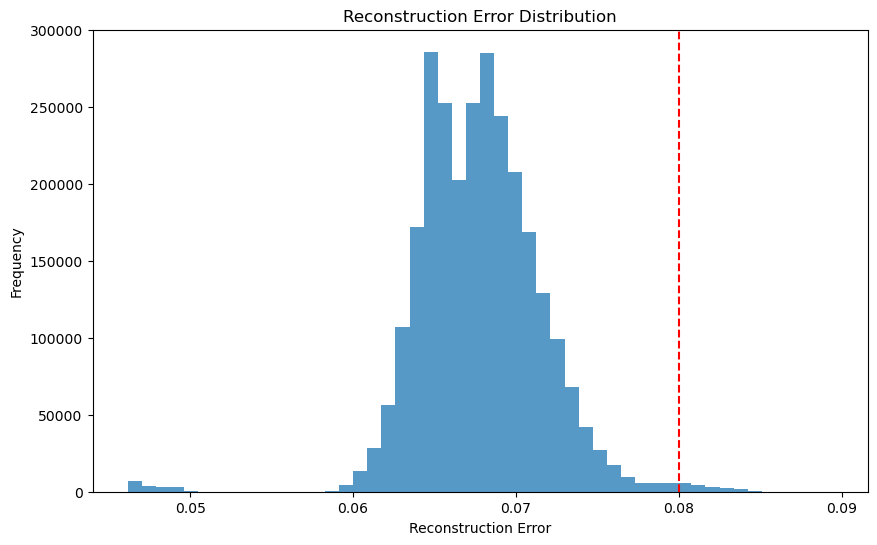

Detected 16,761 anomalies out of 2,728,569 samples.


In [21]:
# Directory where the separate Parquet files are stored
fragments_dir = r'X:\Processed_data'

# Iterate through the fragment files
fragment_files = [
    os.path.join(fragments_dir, f)
    for f in os.listdir(fragments_dir)
    if f.endswith('.parquet')
]

file_number = 5

# Ensure that device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained model
# Assuming 'model' is your trained model
# If you have saved the model, load it using:
# model.load_state_dict(torch.load('autoencoder_epoch_10.pth'))
model = AutoEncoder(hidden_units1, hidden_units2, latent_features)
model.to(device)

# Read the data from the Parquet file
print(fragment_files[file_number])
parquet_file = pq.ParquetFile(fragment_files[file_number])
data_table = parquet_file.read()
data = data_table.to_pandas().to_numpy(dtype='float32')


# Call the detect_anomalies function
anomalies, reconstruction_errors = detect_anomalies_in_batches(data, model, device)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.08, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(data):,} samples.")

In [10]:
data_table = pq.read_table(fragment_files[file_number])
data_df = data_table.to_pandas()
data_df['reconstruction_error'] = reconstruction_errors
data_df['anomaly'] = anomalies

In [35]:
#data_df.head(25)

## Test på valideringsdata

In [25]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import logging
from joblib import Parallel, delayed  # Import Parallel and delayed for parallel processing

def prepare_single_file(input_path, input_file, output_path, window_size=30, num_cores=-1):
    """
    Scales specified columns, drops unnecessary columns, creates sliding windows with chunk and parallel processing,
    aligns timestamps, and returns the prepared DataFrame.
    
    Parameters:
    - input_path (str): Directory containing the input Parquet file.
    - input_file (str): Name of the input Parquet file.
    - output_path (str): Directory to save the processed Parquet file.
    - window_size (int): Size of the sliding window.
    - num_cores (int): Number of cores to use for parallel processing. Default is -1 (all cores).
    
    Returns:
    - prepared_df (pd.DataFrame): DataFrame with windowed features and aligned timestamps.
    """
    # Specify the columns to scale
    columns_to_scale = [
        'RTD', '1st Suc.', 'Cond. Air In', 'Evap. In', 'Evap. Out', 
        '2nd Suc.', 'Chil. water In', '2nd Sump', 'H.E.', 
        'SetPoint', 'Mains Voltage'
    ]
    
    # Full path to the input file
    input_file_path = os.path.join(input_path, input_file)
    
    # Load the data
    try:
        data = pd.read_parquet(input_file_path)
        logging.info(f"Loaded data from {input_file_path}")
    except Exception as e:
        logging.error(f"Error loading {input_file_path}: {e}")
        return None
    
    # Check if all required columns are present
    missing_columns = [col for col in columns_to_scale if col not in data.columns]
    if missing_columns:
        logging.error(f"Missing columns in the data: {missing_columns}")
        return None
    
    # Step 1: Drop unnecessary columns
    drop_columns_set_1 = ['State', 'Type', 'Event']
    drop_columns_set_2 = drop_columns_set_1 + ['main_fault']
    if 'main_fault' in data.columns:
        # Drop columns from drop_columns_set_2 if they exist in the DataFrame
        data = data.drop(columns=[col for col in drop_columns_set_2 if col in data.columns])
        logging.info(f"Dropped columns: {', '.join([col for col in drop_columns_set_2 if col in data.columns])}")
    else:
        # Drop columns from drop_columns_set_1 if they exist in the DataFrame
        data = data.drop(columns=[col for col in drop_columns_set_1 if col in data.columns])
        logging.info(f"Dropped columns: {', '.join([col for col in drop_columns_set_1 if col in data.columns])}")
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the specified columns
    data_scaled = data.copy()
    data_scaled[columns_to_scale] = scaler.fit_transform(data_scaled[columns_to_scale])
    logging.info("Scaling completed.")
    
    # Convert 'Datetime' to datetime format if not already
    if not np.issubdtype(data_scaled['Datetime'].dtype, np.datetime64):
        data_scaled['Datetime'] = pd.to_datetime(data_scaled['Datetime'])
        logging.info("'Datetime' column converted to datetime format.")
    
    # Sort data by 'Datetime' to ensure chronological order
    data_scaled = data_scaled.sort_values('Datetime').reset_index(drop=True)
    
    # Identify continuous sequences based on time differences
    data_scaled['time_diff'] = data_scaled['Datetime'].diff().dt.total_seconds()
    # Assuming continuous if time_diff is between 1 and 120 seconds
    data_scaled['is_continuous'] = (data_scaled['time_diff'].between(1, 120)) | (data_scaled.index == 0)
    data_scaled['sequence_group'] = (~data_scaled['is_continuous']).cumsum()
    
    # Filter sequences that are at least window_size long
    valid_sequences = data_scaled.groupby('sequence_group').filter(lambda x: len(x) >= window_size)
    logging.info(f"Filtered sequences with at least {window_size} continuous samples.")
    
    # Define feature columns (excluding non-feature columns)
    feature_columns = [col for col in valid_sequences.columns 
                       if col not in ['Datetime', 'time_diff', 'is_continuous', 'sequence_group']]
    
    # Reset index after filtering
    valid_sequences = valid_sequences.reset_index(drop=True)
    
    # Define the function to create windows within a chunk
    def create_windows_chunk(start_idx, end_idx, data, window_size, feature_columns):
        windows = []
        timestamps = []
        for idx in range(start_idx, end_idx):
            window = data.iloc[idx:idx + window_size]
            flattened_window = window[feature_columns].values.flatten()
            windows.append(flattened_window)
            # Timestamp corresponding to the latest observation in the window
            latest_timestamp = window['Datetime'].iloc[-1]
            timestamps.append(latest_timestamp)
        return windows, timestamps
    
    # Total number of possible windows
    total_windows = len(valid_sequences) - window_size + 1
    
    # Define chunk size (number of windows per chunk)
    chunk_size = 50  # Adjust based on memory and performance considerations
    
    # Create list of (start_idx, end_idx) tuples for each chunk
    chunks = [(i, min(i + chunk_size, total_windows)) for i in range(0, total_windows, chunk_size)]
    logging.info(f"Total windows: {total_windows}, Processing in {len(chunks)} chunks of up to {chunk_size} windows each.")
    
    # Process each chunk in parallel
    results = Parallel(n_jobs=num_cores)(
        delayed(create_windows_chunk)(start, end, valid_sequences, window_size, feature_columns) 
        for start, end in chunks
    )
    
    # Collect all windows and timestamps from the parallel results
    windows = [window for chunk in results for window in chunk[0]]
    timestamps = [ts for chunk in results for ts in chunk[1]]
    
    # Create column names for the flattened data
    window_features = []
    for t in range(window_size):
        for feature in feature_columns:
            window_features.append(f'{feature}_t{t+1}')
    
    # Convert windows to DataFrame
    windows_df = pd.DataFrame(windows, columns=window_features)
    windows_df['Timestamp'] = timestamps  # Append the timestamp
    logging.info(f"Created {len(windows_df)} windows with window size {window_size}.")
    
    # Remove the first 'window_size' rows as per user instruction
    if len(windows_df) > window_size:
        windows_df = windows_df.iloc[window_size:].reset_index(drop=True)
        logging.info(f"Removed the first {window_size} rows after windowing.")
    
    # Shift the timestamp by 'window_size' rows down
    windows_df['Timestamp'] = windows_df['Timestamp'].shift(-window_size)
    
    # Remove the last 'window_size' rows which have NaN timestamps after shifting
    windows_df = windows_df.dropna(subset=['Timestamp']).reset_index(drop=True)
    logging.info(f"Shifted timestamps by {window_size} rows and removed NaN entries.")
    
    # Reorder columns to have 'Timestamp' first
    cols = windows_df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Timestamp')))
    windows_df = windows_df[cols]
    
    # Optionally, save the prepared DataFrame to a new Parquet file
    output_file = f"prepared_{input_file.replace('.parquet', '')}.parquet"
    output_file_path = os.path.join(output_path, output_file)
    try:
        windows_df.to_parquet(output_file_path, index=False)
        logging.info(f"Saved prepared data to {output_file_path}")
    except Exception as e:
        logging.error(f"Error saving prepared data: {e}")
    
    return windows_df

In [27]:
input_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/Unused clean/'
output_path = input_path
input_file = "cleaned_data_806023.parquet"

data_df = prepare_single_file(input_path, input_file, output_path, window_size=30)

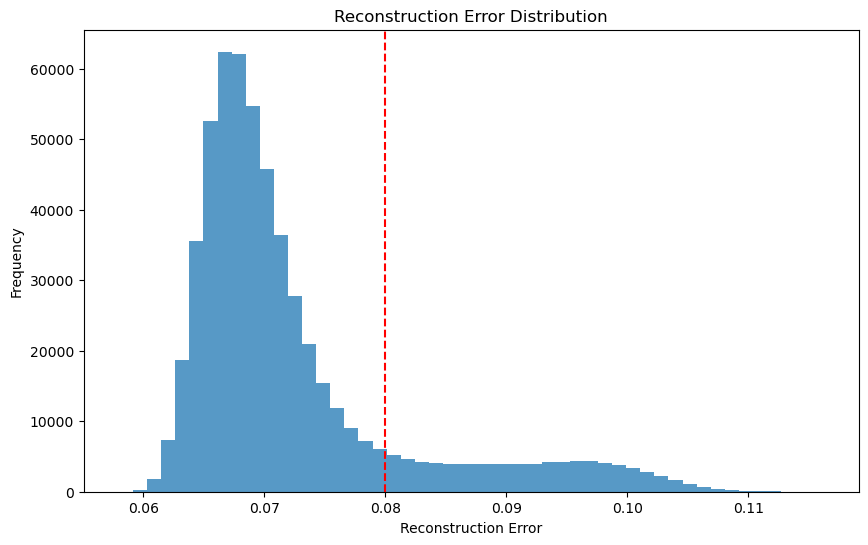

Detected 83,738 anomalies out of 559,098 samples.


In [29]:
# Ensure that device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(hidden_units1, hidden_units2, latent_features)
model.to(device)

data_plot_df = data_df.drop(columns=['Timestamp'])

data = data_plot_df.to_numpy(dtype='float32')

# Call the detect_anomalies function
anomalies, reconstruction_errors = detect_anomalies_in_batches(data, model, device)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.08, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(data):,} samples.")

In [ ]:
df = pd.read_parquet(input_path + input_file)

df['reconstruction_error'] = reconstruction_errors
df['anomaly'] = anomalies

C:\Users\claes\AppData\Local\Temp\ipykernel_36444\2815628688.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\claes\anaconda3\envs\dask_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


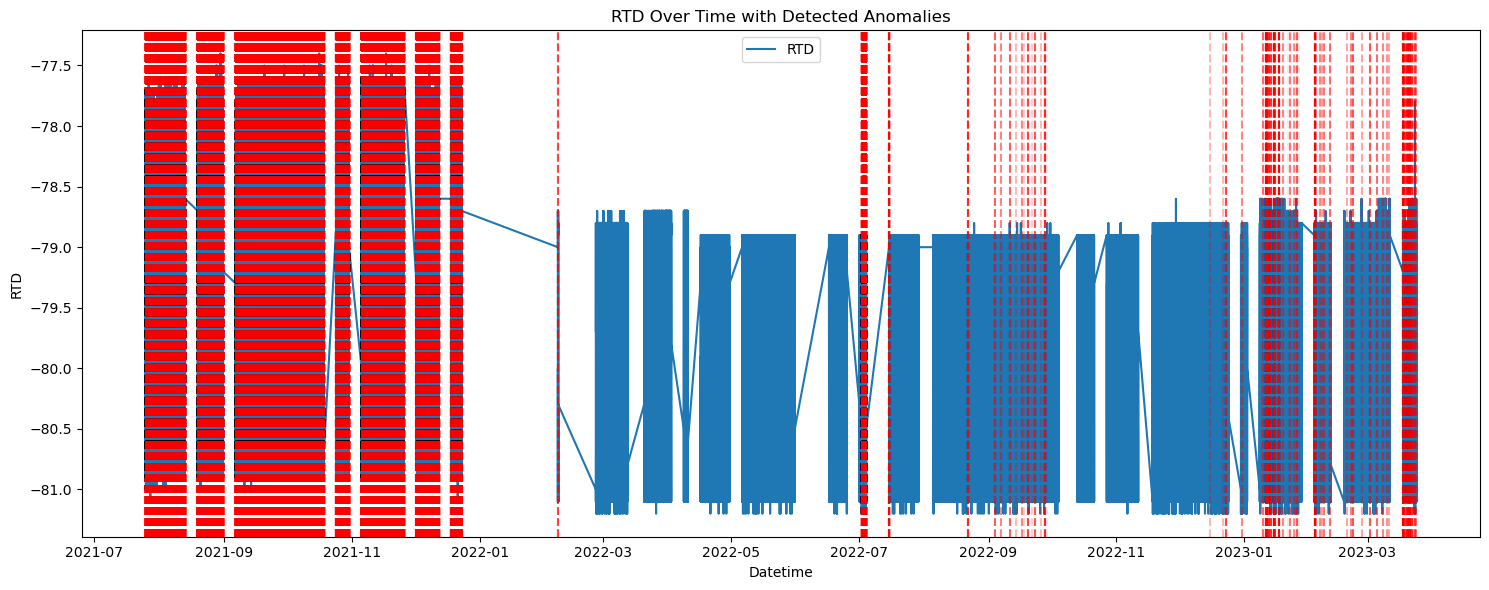

In [34]:
# Load the original data
original_df = pd.read_parquet(os.path.join(input_path, input_file))

# Ensure 'Datetime' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(original_df['Datetime']):
    original_df['Datetime'] = pd.to_datetime(original_df['Datetime'])
    logging.info("'Datetime' column converted to datetime format in original_df.")

# Identify the first column to plot (excluding 'Datetime' if present)
first_column = original_df.columns[0]
if first_column == 'Datetime':
    first_column = original_df.columns[1]  # Assuming 'Datetime' is the first column

# Extract anomaly timestamps from data_df
anomaly_timestamps = data_df['Timestamp'][data_df['anomaly']].values

# Plot the first column over time
plt.figure(figsize=(15, 6))
plt.plot(original_df['Datetime'], original_df[first_column], label=first_column)

# Add vertical red lines for anomalies
for ts in anomaly_timestamps:
    plt.axvline(x=ts, color='r', linestyle='--', alpha=0.1)

plt.title(f'{first_column} Over Time with Detected Anomalies')
plt.xlabel('Datetime')
plt.ylabel(first_column)
plt.legend()
plt.tight_layout()
plt.show()